# Import Stuff

In [1]:
import os
import time
import torch 
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
import numpy as np
import cv2
import seaborn as sns
import matplotlib.pyplot as plt
import onnx
import onnxruntime

from sklearn.metrics.pairwise import cosine_similarity
from PIL import Image
from torchvision import transforms
from matplotlib import pyplot as plt

from matching import matching
from evaluation.metrics import createPR, recallAt100precision, recallAtK
from datasets.load_dataset import GardensPointDataset, SFUDataset, StLuciaDataset

# conda install pytorch torchvision torchaudio pytorch-cuda=11.8 -c pytorch -c nvidia
# conda install onnx onnxruntime
# pip install torch torchvision numpy opencv-python seaborn matplotlib scikit-learn pillow onnxscript

c:\Users\Irfan Q\miniconda3\envs\bruh\Lib\site-packages\onnxruntime\capi\onnxruntime_validation.py:26: UserWarning: Unsupported Windows version (11). ONNX Runtime supports Windows 10 and above, only.
  warnings.warn(


# Load Datasets

In [2]:
imgs_db, imgs_q, GThard, GTsoft = GardensPointDataset().load()
# imgs_db, imgs_q, GThard, GTsoft = SFUDataset().load()
# imgs_db, imgs_q, GThard, GTsoft = StLuciaDataset().load()

print(type(imgs_db))
print(type(imgs_q))
print(type(GThard))
print(type(GTsoft))

===== Load dataset GardensPoint day_right--night_right
<class 'list'>
<class 'list'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


# Preprocess Images

In [3]:
preprocess = transforms.Compose([
    # transforms.Resize((360, 640), interpolation=Image.BICUBIC), # not sure if this is good - added it for quantization
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [4]:
class CustomImageDataset(Dataset):
    def __init__(self, imgs, transform=None):
        self.imgs = imgs
        self.transform = transform

    def __len__(self):
        return len(self.imgs_db)
    
    def __getitem__(self, idx) :
        img = self.imgs_db[idx]
        img = Image.fromarray(img)

        if self.transform:
            img = self.transform(img)

        return(img)

In [5]:
db_tensor = []

for img in imgs_db:
    img = preprocess(Image.fromarray(img))
    db_tensor.append(img)

# Convert list of tensors to a single tensor
db_tensor = torch.stack(db_tensor, axis=0)

print(db_tensor.shape)

torch.Size([200, 3, 540, 960])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


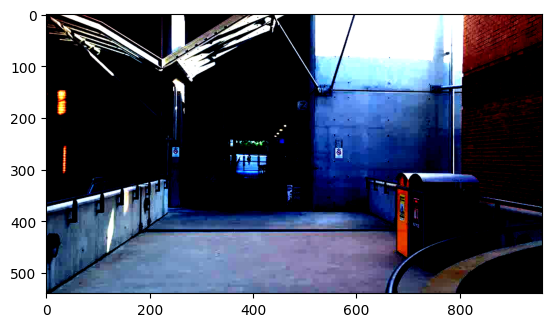

In [6]:
# Display the image
plt.imshow(db_tensor[0].permute(1, 2, 0).detach().numpy())
plt.show()

In [7]:
q_tensor = []

for img in imgs_q:
    img = preprocess(Image.fromarray(img))
    q_tensor.append(img)

# Convert list of tensors to a single tensor
q_tensor = torch.stack(q_tensor, axis=0)

print(q_tensor.shape)

torch.Size([200, 3, 360, 640])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


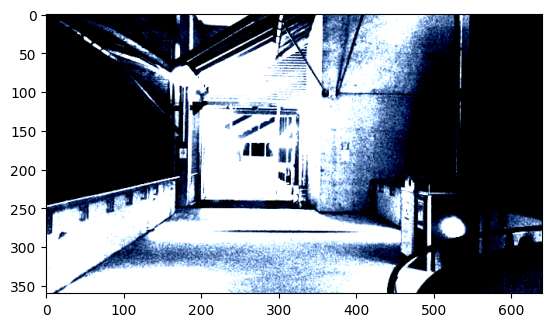

In [8]:
# Display the image
plt.imshow(q_tensor[0].permute(1, 2, 0).detach().numpy())
plt.show()

In [9]:
db_dataset = CustomImageDataset(imgs_db, transform=preprocess)
q_dataset = CustomImageDataset(imgs_q, transform=preprocess)

batch_size = 32
db_dataloader = DataLoader(db_tensor, batch_size=batch_size, shuffle=False, num_workers=16)
q_dataloader = DataLoader(q_tensor, batch_size=batch_size, shuffle=False, num_workers=16)

# Model Definition

In [10]:
model = torch.hub.load("gmberton/cosplace", "get_trained_model", backbone="ResNet50", fc_output_dim=2048)

print(model)

print(dir(model))

Using cache found in C:\Users\Irfan Q/.cache\torch\hub\gmberton_cosplace_main


Returning CosPlace model with backbone: ResNet50 with features dimension 2048
GeoLocalizationNet(
  (backbone): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     

In [11]:
# set the model to inference mode
model.eval()

example_input = torch.randn(1, 3, 360, 640, requires_grad=True)

example_output = model(example_input)

dynamic_axes = {"input": {0: "batch_size"}, "output": {0: "batch_size"}}

# Export the model
torch.onnx.export(
    model,  # model
    example_input,  # example input
    "cosplace_model.onnx",  # output file name
    export_params=True,  # export model parameters
    input_names=["input"],  # input names
    output_names=["output"],  # output names
    dynamic_axes=dynamic_axes,  # dynamic axes
)

ort_session = onnxruntime.InferenceSession("cosplace_model.onnx")

C:\Users\Irfan Q/.cache\torch\hub\gmberton_cosplace_main\cosplace_model\layers.py:30: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  assert x.shape[2] == x.shape[3] == 1, f"{x.shape[2]} != {x.shape[3]} != 1"


SymbolicValueError: Failed to export a node '%531 : Long(device=cpu) = onnx::Squeeze(%529, %530), scope: cosplace_model.cosplace_network.GeoLocalizationNet::/torch.nn.modules.container.Sequential::aggregation/cosplace_model.layers.GeM::aggregation.1 # C:\Users\Irfan Q/.cache\torch\hub\gmberton_cosplace_main\cosplace_model\layers.py:9:0
' (in list node %541 : int[] = prim::ListConstruct(%531, %540), scope: cosplace_model.cosplace_network.GeoLocalizationNet::/torch.nn.modules.container.Sequential::aggregation/cosplace_model.layers.GeM::aggregation.1
) because it is not constant. Please try to make things (e.g. kernel sizes) static if possible.  [Caused by the value '541 defined in (%541 : int[] = prim::ListConstruct(%531, %540), scope: cosplace_model.cosplace_network.GeoLocalizationNet::/torch.nn.modules.container.Sequential::aggregation/cosplace_model.layers.GeM::aggregation.1
)' (type 'List[int]') in the TorchScript graph. The containing node has kind 'prim::ListConstruct'.] 

    Inputs:
        #0: 531 defined in (%531 : Long(device=cpu) = onnx::Squeeze(%529, %530), scope: cosplace_model.cosplace_network.GeoLocalizationNet::/torch.nn.modules.container.Sequential::aggregation/cosplace_model.layers.GeM::aggregation.1 # C:\Users\Irfan Q/.cache\torch\hub\gmberton_cosplace_main\cosplace_model\layers.py:9:0
    )  (type 'Tensor')
        #1: 540 defined in (%540 : Long(device=cpu) = onnx::Squeeze(%538, %539), scope: cosplace_model.cosplace_network.GeoLocalizationNet::/torch.nn.modules.container.Sequential::aggregation/cosplace_model.layers.GeM::aggregation.1 # C:\Users\Irfan Q/.cache\torch\hub\gmberton_cosplace_main\cosplace_model\layers.py:9:0
    )  (type 'Tensor')
    Outputs:
        #0: 541 defined in (%541 : int[] = prim::ListConstruct(%531, %540), scope: cosplace_model.cosplace_network.GeoLocalizationNet::/torch.nn.modules.container.Sequential::aggregation/cosplace_model.layers.GeM::aggregation.1
    )  (type 'List[int]')

# Run Models

This cell makes my computer lag

In [ ]:
# # Pass database tensor through the model
# db_features = model(db_tensor)
# print(db_features.shape)

# # Pass query tensor through the model
# q_features = model(q_tensor)
# print(q_features.shape)

In [ ]:
model.eval()

# Pass database tensor through the model

db_features = []

with torch.no_grad():

    for batch in db_dataloader:
        output = model(batch)
        db_features.append(output)

db_features = torch.cat(db_features, axis=0)

print(db_features.shape)

# Pass query tensor through the model

q_features = []

with torch.no_grad():

    for batch in q_dataloader:
        output = model(batch)
        q_features.append(output)

q_features = torch.cat(q_features, axis=0)

print(q_features.shape)

# Evaluation

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity

db_features_np = db_features.detach().numpy()
q_features_np = q_features.detach().numpy()

# Convert pytorch tensors to numpy arrays
similarity_matrix = cosine_similarity(db_features_np, q_features_np)

print(similarity_matrix.shape)

In [ ]:
plt.figure()
sns.heatmap(similarity_matrix, cmap='viridis')
plt.title('Similarity matrix')
plt.axis('off')
plt.show()